<a href="https://colab.research.google.com/github/CGarcia8CG/SHAP_example/blob/main/SHAP_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install scikit-optimize
!pip install shap

In [26]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report

import shap
from skopt import BayesSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# Random data
X, y = make_classification(n_samples=10000, n_features=5, n_informative=4, n_redundant=1, n_clusters_per_class=2,
                           random_state=42, n_classes=2, weights={0:0.6, 1:0.4})

In [28]:
X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y_df = pd.DataFrame({'target': y})

# Concatenate X_df and y_df along columns (axis=1)
combined_df = pd.concat([X_df, y_df], axis=1)
print(combined_df.shape)
combined_df.head()

(10000, 6)


,feature_0,feature_1,feature_2,feature_3,feature_4,target
0,0.087048,2.426520,1.185854,1.782523,0.935856,1
1,-1.707593,0.122327,-0.604671,-0.905535,-0.692637,0
2,-0.981501,0.547214,-1.312135,-1.022361,0.818510,1
3,0.805849,-1.691910,-2.878510,-0.472700,-0.355966,0
4,-0.137834,-3.258149,-1.794420,-2.837373,-0.770304,1


In [29]:
X_combined = combined_df.drop(columns=['target'])  # Features
y_combined = combined_df['target']  # Target variable

# Split the data into training and testing sets
# Stratify for keep the unbalanced condition 60/40
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

In [30]:
y_train.value_counts()
y_test.value_counts()

0    1196
1     804
Name: target, dtype: int64

## Model

In [31]:
# Define the RandomForestClassifier
rf_classifier_bayes = RandomForestClassifier()

# Hyperparameter space for BayesianSearchCV
param_dist = {
    'n_estimators': (50, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

f1_macro_scorer = make_scorer(f1_score, average='macro')

# Create BayesSearchCV instance with F1-score macro as the scoring metric
bayesian_search = BayesSearchCV(estimator=rf_classifier_bayes, search_spaces=param_dist, n_iter=50, cv=5, random_state=42, scoring=f1_macro_scorer)

# Fit the model with BayesianSearchCV
bayesian_search.fit(X_train, y_train)

# Display results
print("BayesianSearchCV - Best Parameters:", bayesian_search.best_params_)
print("BayesianSearchCV - Best F1-score (macro):", bayesian_search.best_score_)

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


BayesianSearchCV - Best Parameters: OrderedDict([('max_depth', 15), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 178)])
BayesianSearchCV - Best F1-score (macro): 0.9235506502755941


In [32]:
# Predictions on the test set
y_pred_bayesian = bayesian_search.predict(X_test)

# Classification report for BayesianSearchCV model
print("\nBayesianSearchCV Model Classification Report:")
print(classification_report(y_test, y_pred_bayesian))


BayesianSearchCV Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1196
           1       0.93      0.92      0.92       804

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [33]:
# Explain the model using SHAP
explainer = shap.TreeExplainer(bayesian_search.best_estimator_)
shap_values = explainer.shap_values(X_test)

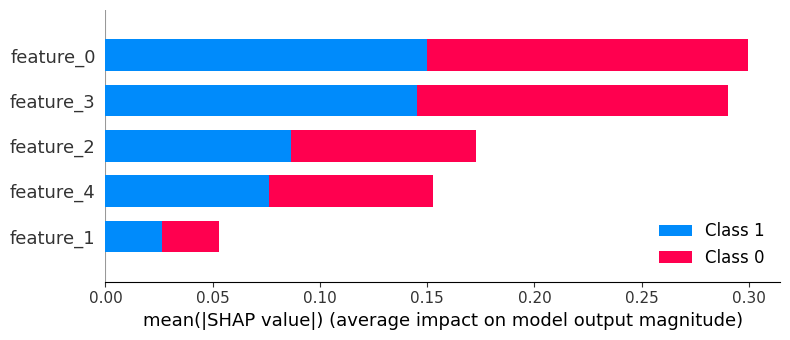

In [34]:
# Summary plot
shap.summary_plot(shap_values, X_test)

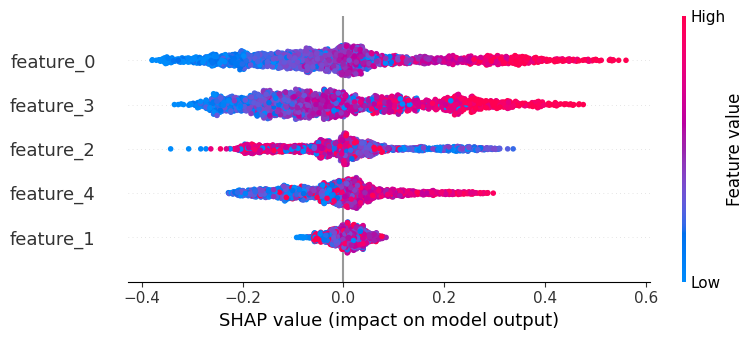

In [35]:
# Select a class for the summary plot
class_index = 1  # Change this index as needed

# Create a summary plot for a single class
shap.summary_plot(shap_values[class_index], X_test)

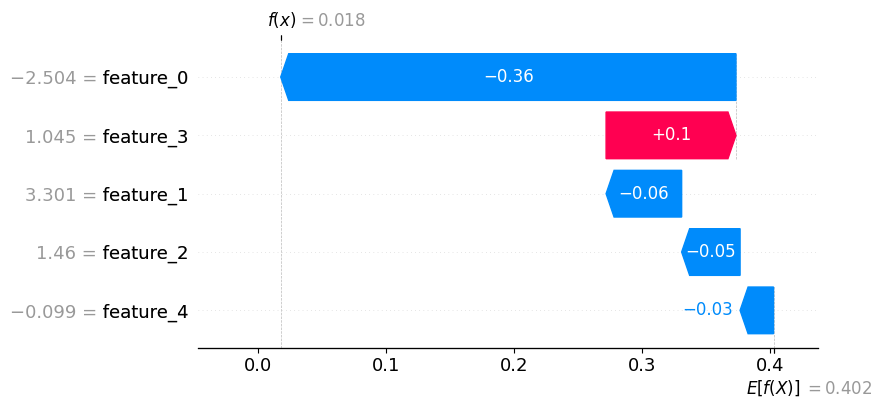

In [36]:
class_index = 1
expected_v = 1
sample_index = 32

shap_values_obj = shap.Explanation(values=shap_values[class_index][sample_index, :], base_values=explainer.expected_value[expected_v], data=X_test.iloc[sample_index, :])
shap.waterfall_plot(shap_values_obj)

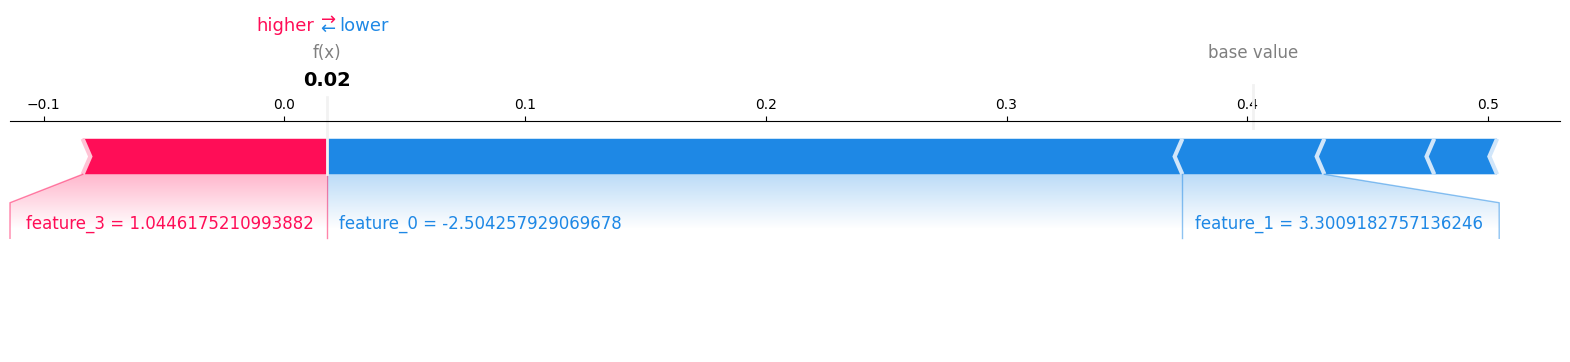

In [37]:
shap.plots.force(explainer.expected_value[1], shap_values[1][32,:], X_test.iloc[32, :], matplotlib = True)

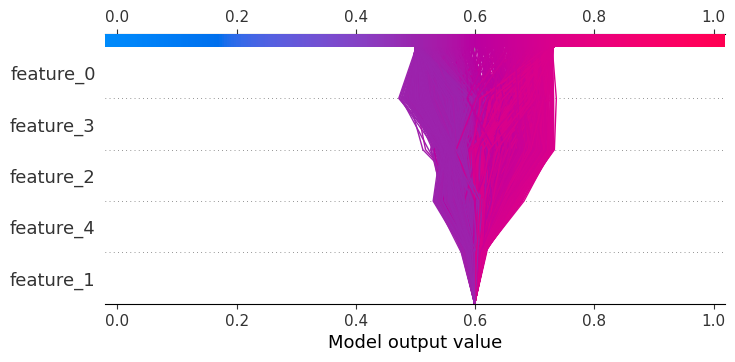

In [38]:
# Create a multi-class decision plot
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test, link='logit')

In [39]:
#shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], X_test, show=False)
